<a href="https://colab.research.google.com/github/Asifhonor/Sentinel-data/blob/main/Final_Pygmtsar7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Platform, sys, Operating Sys (os)**

In [1]:
import platform, sys, os

# **Install GMTSAR**

In [2]:
import os  # Import the os module

# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

env: PATH=/opt/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/local/GMTSAR/bin/


In [3]:
import sys
import subprocess
# use default GMTSAR installation path if it's not already in PATH
if 'GMTSAR' not in os.environ['PATH']:
    os.environ['PATH'] += ':/usr/local/GMTSAR/bin/'

if 'google.colab' in sys.modules:
    count = !ls /usr/local | grep GMTSAR | wc -l
    if count == ['0']:
        !export DEBIAN_FRONTEND=noninteractive
        !apt-get update > /dev/null
        !apt install -y csh autoconf gfortran \
            libtiff5-dev libhdf5-dev liblapack-dev libgmt-dev gmt > /dev/null
        # GMTSAR codes are not so good to be compiled by modern GCC
        !apt install gcc-9 > /dev/null
        !update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 10
        !update-alternatives --config gcc
        !gcc --version | head -n 1
        !rm -fr /usr/local/GMTSAR
        !git config --global advice.detachedHead false
        !cd /usr/local && git clone -q --branch master https://github.com/gmtsar/gmtsar GMTSAR
        # revert recent broken commit
        !cd /usr/local/GMTSAR && git checkout e98ebc0f4164939a4780b1534bac186924d7c998 > /dev/null
        !cd /usr/local/GMTSAR && autoconf > /dev/null
        !cd /usr/local/GMTSAR && ./configure --with-orbits-dir=/tmp > /dev/null
        !cd /usr/local/GMTSAR && make 1>/dev/null 2>/dev/null
        !cd /usr/local/GMTSAR && make install >/dev/null
        # fix for missed script, use bash instead of csh interpretator
        # note: csh messes stdout and stderr in Docker environment, it's resolved in PyGMTSAR code
        !echo '#!/bin/sh' > /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !echo echo /usr/local/GMTSAR/share/gmtsar >> /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !chmod a+x /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !/usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        # test one GMTSAR binary
        !/usr/local/GMTSAR/bin/make_s1a_tops 2>&1 | head -n 2

In [4]:
import sys
import subprocess

if 'google.colab' in sys.modules:
    # Install xvfb package
    subprocess.run(['apt', 'install', '-y', 'xvfb'], check=True)

    # Install Python packages pyvista and xvfbwrapper
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pyvista', 'xvfbwrapper'], check=True)

    # Import xvfbwrapper and start virtual display
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

# **Python Version**

In [5]:
!{sys.executable} --version

Python 3.10.12


# **Install Pygmtsar**

In [6]:
!pip install pandas==2.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 26.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygmtsar 2024.4.17 requires pandas>=2.2, but you have pandas 2.0.3 which is incompatible.


In [7]:
import sys
import subprocess
if 'google.colab' in sys.modules:
    #!{sys.executable} -m pip install -q git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    !{sys.executable} -m pip install -q pygmtsar==2024.4.17
from pygmtsar import __version__
__version__

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


'2024.4.17'

# **Load and setup Python Module**

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask

In [9]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

<ipython-input-9-ef9149b47a14>:6: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  panel.extension('vtk')


In [10]:
# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Descending Orbit **Configuration**            
https://search.asf.alaska.edu/#/?start=2019-01-01T00:00:00Z&resultsLoaded=true&zoom=8.072&center=77.532,22.305&end=2019-02-28T23:59:59Z&productTypes=SLC&path=63-&frame=514-&granule=S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE-SLC


In [11]:
#Path 63 frame 514
SCENES =  ['S1A_IW_GRDH_1SDV_20190129T004517_20190129T004542_025685_02DA81_7C70'
           'S1A_IW_GRDH_1SDV_20190117T004518_20190117T004543_025510_02D41D_1CAD'
           'S1A_IW_GRDH_1SDV_20190105T004518_20190105T004543_025335_02CDCB_D0A5']
POLARIZATION = 'VV+VH'
ORBIT        = 'D'
SUBSWATH     = 123





In [12]:
WORKDIR      = '/content'
DATADIR      = '/content/extracted'
# output resolution defined as float value, meter
RESOLUTION   = 200.

In [13]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'
LANDMASK = f'{DATADIR}/landmask.nc'

In [14]:
import geopandas as gpd
import shapely.geometry

# Define the coordinates for measuring subsidence
coordinates = [
    [78.579643, 22.482553],
    [78.900314, 23.992012],
    [76.449226, 24.409269],
    [76.156799, 22.902924],
    [78.579643, 22.482553]
]

# Create Shapely polygon from the coordinates
polygon = shapely.geometry.Polygon(coordinates)

# Create a GeoDataFrame with the polygon
subsidence_area = gpd.GeoDataFrame(geometry=[polygon])

# Display the GeoDataFrame
print(subsidence_area)


                                                                                              geometry
0  POLYGON ((78.57964 22.48255, 78.90031 23.99201, 76.44923 24.40927, 76.15680 22.90292, 78.57964 2...


# Download and Unpack Datasets (Optional)**bold text**

In [15]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'eu3b2km6k'
asf_password = 'Sunny@90909090/'

In [16]:
pip show asf_search

Name: asf_search
Version: 7.1.1
Summary: Python wrapper for ASF's SearchAPI
Home-page: https://github.com/asfadmin/Discovery-asf_search.git
Author: Alaska Satellite Facility Discovery Team
Author-email: uaf-asf-discovery@alaska.edu
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: ciso8601, dateparser, importlib-metadata, numpy, pytz, requests, shapely, tenacity
Required-by: pygmtsar


In [17]:
import asf_search as asf

granules = [
        'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE',
    'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831',
    'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC'
]

results = asf.granule_search(granules)
print(results)



{
  "features": [
    {
      "geometry": {
        "coordinates": [
          [
            [
              78.579094,
              22.47662
            ],
            [
              78.92688,
              24.111303
            ],
            [
              76.453438,
              24.531622
            ],
            [
              76.137581,
              22.900173
            ],
            [
              78.579094,
              22.47662
            ]
          ]
        ],
        "type": "Polygon"
      },
      "properties": {
        "beamModeType": "IW",
        "browse": null,
        "bytes": 4535233770,
        "centerLat": 23.5098,
        "centerLon": 77.5263,
        "fileID": "S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE-SLC",
        "fileName": "S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip",
        "flightDirection": "DESCENDING",
        "frameNumber": 514,
        "granuleType": "SENTINEL_1A_FRAME",
        "

In [18]:
import os
os.getcwd()


'/content'

In [19]:
os.listdir()


['.config',
 'copernicus_dem.tif',
 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip',
 'Downloads',
 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip',
 'extracted',
 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip',
 'output_directory',
 'sample_data']

In [20]:
import os
import zipfile

# Define the directory containing the ZIP files
zip_dir = '/content/'

# Create a new directory for extracted files if it doesn't exist
extracted_dir = os.path.join(zip_dir, 'extracted')
os.makedirs(extracted_dir, exist_ok=True)

# Get the list of ZIP files in the directory
zip_files = [f for f in os.listdir(zip_dir) if f.endswith('.zip')]

# Extract each ZIP file into the extracted directory
for zip_file in zip_files:
    with zipfile.ZipFile(os.path.join(zip_dir, zip_file), 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

print("Extraction complete.")


Extraction complete.


In [21]:
pip install git+https://github.com/asfadmin/asf_search.git


  Cloning https://github.com/asfadmin/asf_search.git to /tmp/pip-req-build-1mhegv6e
  Running command git clone --filter=blob:none --quiet https://github.com/asfadmin/asf_search.git /tmp/pip-req-build-1mhegv6e
  Resolved https://github.com/asfadmin/asf_search.git to commit 1bf62d1f26530151a83e3202dd70d90581840ee2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [22]:
import os

# Define the path for the new directory
output_directory = '/content/output_directory'

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory '{output_directory}' created successfully!")
else:
    print(f"Directory '{output_directory}' already exists!")

# Now you can use output_directory for further operations


Directory '/content/output_directory' already exists!


In [23]:
!pip install sentinelhub


In [24]:
!python -m pip install asf_tools

In [25]:
import os

# Set the PYTHONPATH to the directory containing the asf_search package
asf_search_path = "/usr/local/lib/python3.10/dist-packages/asf_search"
os.environ["PYTHONPATH"] = asf_search_path

# Check if the PYTHONPATH is set correctly
print("PYTHONPATH set to:", os.environ.get("PYTHONPATH"))


PYTHONPATH set to: /usr/local/lib/python3.10/dist-packages/asf_search


In [26]:
from pygmtsar import ASF

In [27]:
from pygmtsar import ASF
import geopandas as gpd
import json

# Define your ASF username and password
asf_username = "eu3b2km6k"
asf_password = "Sunny@90909090/"

# Create an instance of the ASF class
asf = ASF(asf_username, asf_password)

# Define the area of interest (AOI) as a GeoDataFrame
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [78.569031, 22.426884],
        [78.915009, 24.053654],
        [76.473228, 24.469149],
        [76.158539, 22.845547],
        [78.569031, 22.426884]
      ]
    ]
  },
  "properties": {}
}
'''

AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

# Download scenes from ASF
DATADIR = "/content/Downloads"
SCENES = [
    "S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE",
    "S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831",
    "S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC"
]  # Replace with the list of scenes you want to download
SUBSWATH = "IW"  # Specify the subswath you want to download

# Set these variables to None and you will be prompted to enter your username and password below.
print(asf.download_scenes(DATADIR, SCENES, SUBSWATH))


ASF Downloading Sentinel-1 SLC::   0%|          | 0/3 [00:00<?, ?it/s]

                                                                 scene
0  S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC
1  S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831
2  S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE


In [28]:
pip install wget

In [30]:
import os
os.getcwd()

'/content'

In [31]:
os.listdir()


['.config',
 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip.1',
 'copernicus_dem.tif',
 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip',
 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip.1',
 'Downloads',
 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip',
 'extracted',
 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip',
 'output_directory',
 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip.1',
 'sample_data']

# Download data using asf **credential**

!wget --user=eu3b2km6k --password=Sunny@90909090/ "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip"

!wget --user=eu3b2km6k --password=Sunny@90909090/ "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip"

!wget --user=eu3b2km6k --password=Sunny@90909090/ "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip"

In [33]:
import os

# List of files
files = ['.config',
 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip.1',
 'copernicus_dem.tif',
 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip',
 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip.1',
 'Downloads',
 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip',
 'extracted',
 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip',
 'output_directory',
 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip.1',
 'sample_data']

# Create a dictionary to store file names without extensions as keys and the original file names as values
file_dict = {}
for file in files:
    filename, file_extension = os.path.splitext(file)
    if filename not in file_dict:
        file_dict[filename] = file
    else:
        # Remove duplicate file
        os.remove(file)

# Print the remaining files after removing duplicates
print("Files after removing duplicates:")
print(list(file_dict.values()))


Files after removing duplicates:
['.config', 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip.1', 'copernicus_dem.tif', 'S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.zip', 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip.1', 'Downloads', 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip', 'extracted', 'S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.zip', 'output_directory', 'S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.zip.1', 'sample_data']


In [35]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the extracted directory is in the current working directory
extracted_dir = os.path.join(current_dir, 'extracted')

print("Path to extracted directory:", extracted_dir)


Path to extracted directory: /content/extracted


In [36]:
DATADIR = "/content/extracted"

In [38]:
from pygmtsar import S1

# Scan the data directory for SLC scenes
scanned_scenes = S1.scan_slc(DATADIR)

# Download missed orbits
S1.download_orbits(DATADIR, scanned_scenes)



NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [39]:
from pygmtsar import Tiles
import geopandas as gpd
import json

# Define the area of interest (AOI) as a GeoDataFrame
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [78.569031, 22.426884],
        [78.915009, 24.053654],
        [76.473228, 24.469149],
        [76.158539, 22.845547],
        [78.569031, 22.426884]
      ]
    ]
  },
  "properties": {}
}
'''

# Convert the GeoJSON string to a GeoDataFrame
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

# Define the filename for the downloaded DEM
DEM = 'copernicus_dem.tif'

# Download the Copernicus Global DEM 1 arc-second
Tiles().download_dem(AOI, filename=DEM)

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


<xarray.DataArray 'z' (lat: 7352, lon: 9924)> Size: 292MB
dask.array<open_dataset-z, shape=(7352, 9924), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 79kB 76.16 76.16 76.16 76.16 ... 78.91 78.91 78.92
  * lat      (lat) float64 59kB 22.43 22.43 22.43 22.43 ... 24.47 24.47 24.47
Attributes:
    AREA_OR_POINT:  Point

In [40]:
# download Copernicus Global DEM 1 arc-second
Tiles().download_dem(AOI, filename=DEM)

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


<xarray.DataArray 'z' (lat: 7352, lon: 9924)> Size: 292MB
dask.array<open_dataset-z, shape=(7352, 9924), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 79kB 76.16 76.16 76.16 76.16 ... 78.91 78.91 78.92
  * lat      (lat) float64 59kB 22.43 22.43 22.43 22.43 ... 24.47 24.47 24.47
Attributes:
    AREA_OR_POINT:  Point

In [41]:
# download land mask 1 arc-second
Tiles().download_landmask(AOI, filename=LANDMASK)

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


<xarray.DataArray 'z' (lat: 7352, lon: 9923)> Size: 292MB
dask.array<open_dataset-z, shape=(7352, 9923), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 79kB 76.16 76.16 76.16 76.16 ... 78.91 78.91 78.91
  * lat      (lat) float64 59kB 22.43 22.43 22.43 22.43 ... 24.47 24.47 24.47

In [34]:
import os

# Define the directory containing the extracted data
extracted_dir = 'extracted'

# List all files and directories in the extracted directory
extracted_contents = os.listdir(extracted_dir)

# Print the list of extracted contents
print("Extracted contents:")
for item in extracted_contents:
    print(item)

Extracted contents:
S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF
landmask.nc
S1A_OPER_AUX_POEORB_OPOD_20210310T204435_V20190116T225942_20190118T005942.EOF
S1A_OPER_AUX_POEORB_OPOD_20210311T003555_V20190128T225942_20190130T005942.EOF
S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE.SAFE
S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE
S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE


# Run Local Dask **Cluster**

In [42]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39549
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36025'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38155'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45751'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40697'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43477'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45003'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44801'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34659'
INFO:distributed.nanny:        Start Na

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 334.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39549,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 334.56 GiB
Comm: tcp://127.0.0.1:44835,Total threads: 8
Dashboard: http://127.0.0.1:39575/status,Memory: 27.88 GiB
Nanny: tcp://127.0.0.1:36025,


# Select Original Secenes and **Orbits**
Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [43]:
import os

# Set the PYTHONPATH to the directory containing the asf_search package
asf_search_path = "/usr/local/lib/python3.10/dist-packages/asf_search"
os.environ["PYTHONPATH"] = asf_search_path

# Check if the PYTHONPATH is set correctly
print("PYTHONPATH set to:", os.environ.get("PYTHONPATH"))


PYTHONPATH set to: /usr/local/lib/python3.10/dist-packages/asf_search


In [44]:
from pygmtsar import ASF

In [46]:
from pygmtsar import ASF
import geopandas as gpd
import json

# Define your ASF username and password
asf_username = "eu3b2km6k"
asf_password = "Sunny@90909090/"

# Create an instance of the ASF class
asf = ASF(asf_username, asf_password)

# Define the area of interest (AOI) as a GeoDataFrame
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [78.569031, 22.426884],
        [78.915009, 24.053654],
        [76.473228, 24.469149],
        [76.158539, 22.845547],
        [78.569031, 22.426884]
      ]
    ]
  },
  "properties": {}
}
'''

AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

# Download scenes from ASF
DATADIR = "/content/Downloads"
SCENES = [
    "S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE",
    "S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831",
    "S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC"
]  # Replace with the list of scenes you want to download
SUBSWATH = "IW"  # Specify the subswath you want to download

# Set these variables to None and you will be prompted to enter your username and password below.
print(asf.download_scenes(DATADIR, SCENES, SUBSWATH))


ASF Downloading Sentinel-1 SLC::   0%|          | 0/3 [00:00<?, ?it/s]

                                                                 scene
0  S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC
1  S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831
2  S1A_IW_SLC__1SDV_20190129T004516_20190129T004543_025685_02DA81_B8DE


In [50]:
import pygmtsar as S1

# Check available functions in pygmtsar
print(dir(S1))


['ASF', 'AWS', 'GMT', 'IO', 'NCubeVTK', 'PRM', 'PRM_gmtsar', 'S1', 'Stack', 'Stack_align', 'Stack_base', 'Stack_dem', 'Stack_detrend', 'Stack_export', 'Stack_geocode', 'Stack_incidence', 'Stack_landmask', 'Stack_multilooking', 'Stack_orbits', 'Stack_phasediff', 'Stack_prm', 'Stack_ps', 'Stack_reframe', 'Stack_reframe_gmtsar', 'Stack_sbas', 'Stack_stl', 'Stack_tidal', 'Stack_topo', 'Stack_trans', 'Stack_trans_inv', 'Stack_unwrap', 'Stack_unwrap_snaphu', 'Tiles', 'XYZTiles', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'datagrid', 'tqdm_dask', 'tqdm_joblib', 'utils']


In [55]:
import pygmtsar as S1
import pandas as pd

# Define your data directory
DATADIR = "/content/extracted"

# Specify the subswath you want to scan for
SUBSWATH = 1  # Choose one of the valid subswath values: 1, 2, 3, 12, 23, 123

# Scan the data directory for SLC scenes
scenes = S1.S1.scan_slc(DATADIR, subswath=SUBSWATH)

# Add logging to understand the flow
print("Scanning SLC scenes...")
print("Scanned Scenes:", scenes)

# Download missed orbits
print("Downloading Sentinel-1 Orbits...")
S1.S1.download_orbits(DATADIR, scenes)

# Output found orbits
print("Found orbits:")
print(scenes['orbit'])


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
Scanning SLC scenes...
Scanned Scenes:                       datetime orbit mission polarization  subswath  \
date                                                                  
2019-01-05 2019-01-05 00:45:19     D     S1A           VH         1   
2019-01-05 2019-01-05 00:45:19     D     S1A           VV         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VH         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VV         1   
2019-01-29 2019-01-29 00:45:16     D     S1A           VH         1   
2019-01-29 2019-01-29 00:45:16     D     S1A           VV         1   

                                                                                                       datapath  \
date                                                                                                              
2019-01-05  /content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20

In [56]:
# Output unique found orbits
print("Found orbits:")
print(scenes['orbit'].drop_duplicates())


Found orbits:
date
2019-01-05    D
Name: orbit, dtype: object


In [57]:
print(scenes)


                      datetime orbit mission polarization  subswath  \
date                                                                  
2019-01-05 2019-01-05 00:45:19     D     S1A           VH         1   
2019-01-05 2019-01-05 00:45:19     D     S1A           VV         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VH         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VV         1   
2019-01-29 2019-01-29 00:45:16     D     S1A           VH         1   
2019-01-29 2019-01-29 00:45:16     D     S1A           VV         1   

                                                                                                       datapath  \
date                                                                                                              
2019-01-05  /content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...   
2019-01-05  /content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335

In [60]:
import pygmtsar as S1
import pandas as pd

# Define your data directory
DATADIR = "/content/extracted"

# Scan the data directory for SLC scenes
scanned_scenes = S1.S1.scan_slc(DATADIR)

# Add logging to understand the flow
print("Scanning SLC scenes...")
print("Scanned Scenes:", scanned_scenes)

# Download missed orbits
print("Downloading Sentinel-1 Orbits Index...")
S1.S1.download_orbit_index()
print("Downloading Sentinel-1 Orbits...")
S1.S1.download_orbits(DATADIR, scanned_scenes)

# Output found orbits
print("Found orbits:")
print(scanned_scenes['orbit'])


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
Scanning SLC scenes...
Scanned Scenes:                       datetime orbit mission polarization  subswath  \
date                                                                  
2019-01-05 2019-01-05 00:45:19     D     S1A           VH         1   
2019-01-05 2019-01-05 00:45:19     D     S1A           VV         1   
2019-01-05 2019-01-05 00:45:17     D     S1A           VH         2   
2019-01-05 2019-01-05 00:45:17     D     S1A           VV         2   
2019-01-05 2019-01-05 00:45:18     D     S1A           VH         3   
2019-01-05 2019-01-05 00:45:18     D     S1A           VV         3   
2019-01-17 2019-01-17 00:45:19     D     S1A           VH         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VV         1   
2019-01-17 2019-01-17 00:45:17     D     S1A           VH         2   
2019-01-17 2019-01-17 00:45:17     D     S1A           VV         2   
2019-01-17 20

AttributeError: type object 'S1' has no attribute 'download_orbit_index'

In [61]:
import pygmtsar as S1
import pandas as pd

# Define your data directory
DATADIR = "/content/extracted"

# Scan the data directory for SLC scenes
scanned_scenes = S1.S1.scan_slc(DATADIR)

# Add logging to understand the flow
print("Scanning SLC scenes...")
print("Scanned Scenes:", scanned_scenes)

# Download missed orbits
print("Downloading Sentinel-1 Orbits...")
S1.S1.download_orbits(DATADIR, scanned_scenes)

# Output found orbits
print("Found orbits:")
print(scanned_scenes['orbit'])


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
Scanning SLC scenes...
Scanned Scenes:                       datetime orbit mission polarization  subswath  \
date                                                                  
2019-01-05 2019-01-05 00:45:19     D     S1A           VH         1   
2019-01-05 2019-01-05 00:45:19     D     S1A           VV         1   
2019-01-05 2019-01-05 00:45:17     D     S1A           VH         2   
2019-01-05 2019-01-05 00:45:17     D     S1A           VV         2   
2019-01-05 2019-01-05 00:45:18     D     S1A           VH         3   
2019-01-05 2019-01-05 00:45:18     D     S1A           VV         3   
2019-01-17 2019-01-17 00:45:19     D     S1A           VH         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VV         1   
2019-01-17 2019-01-17 00:45:17     D     S1A           VH         2   
2019-01-17 2019-01-17 00:45:17     D     S1A           VV         2   
2019-01-17 20

In [63]:
import pygmtsar as S1
import pandas as pd

# Define your data directory
DATADIR = "/content/extracted"

# Scan the data directory for SLC scenes
scanned_scenes = S1.S1.scan_slc(DATADIR)

# Add logging to understand the flow
print("Scanning SLC scenes...")
print("Scanned Scenes:", scanned_scenes)

# Download missed orbits
print("Downloading Sentinel-1 Orbits...")
S1.S1.download_orbits(DATADIR, scanned_scenes)

# Output found orbits
print("Found orbits:")
print(scanned_scenes['orbit'])

# Define Stack class
class Stack(S1.Stack):
    pass

# Create Stack object
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scanned_scenes)
sbas.to_dataframe()


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
Scanning SLC scenes...
Scanned Scenes:                       datetime orbit mission polarization  subswath  \
date                                                                  
2019-01-05 2019-01-05 00:45:19     D     S1A           VH         1   
2019-01-05 2019-01-05 00:45:19     D     S1A           VV         1   
2019-01-05 2019-01-05 00:45:17     D     S1A           VH         2   
2019-01-05 2019-01-05 00:45:17     D     S1A           VV         2   
2019-01-05 2019-01-05 00:45:18     D     S1A           VH         3   
2019-01-05 2019-01-05 00:45:18     D     S1A           VV         3   
2019-01-17 2019-01-17 00:45:19     D     S1A           VH         1   
2019-01-17 2019-01-17 00:45:19     D     S1A           VV         1   
2019-01-17 2019-01-17 00:45:17     D     S1A           VH         2   
2019-01-17 2019-01-17 00:45:17     D     S1A           VV         2   
2019-01-17 20

,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2019-01-05,2019-01-05 00:45:19,D,S1A,VH,1,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((78.89142 23.94398, 78.84590 23.95212, 78.80081 23.96016, 78.75613 23.96812, 78.7..."
2019-01-05,2019-01-05 00:45:19,D,S1A,VV,1,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((78.89142 23.94398, 78.84590 23.95212, 78.80081 23.96016, 78.75613 23.96812, 78.7..."
2019-01-05,2019-01-05 00:45:17,D,S1A,VH,2,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((78.10478 24.19615, 78.05783 24.20426, 78.01121 24.21231, 77.96490 24.22028, 77.9..."
2019-01-05,2019-01-05 00:45:17,D,S1A,VV,2,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((78.10478 24.19615, 78.05783 24.20426, 78.01121 24.21231, 77.96490 24.22028, 77.9..."
2019-01-05,2019-01-05 00:45:18,D,S1A,VH,3,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((77.24103 24.28341, 77.20030 24.29022, 77.15975 24.29698, 77.11938 24.30370, 77.0..."
2019-01-05,2019-01-05 00:45:18,D,S1A,VV,3,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190105T004517_20190105T004544_025335_02CDCB_10CC.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T165613_V20190104T225942_20190106T005942.EOF,"MULTIPOLYGON (((77.24103 24.28341, 77.20030 24.29022, 77.15975 24.29698, 77.11938 24.30370, 77.0..."
2019-01-17,2019-01-17 00:45:19,D,S1A,VH,1,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T204435_V20190116T225942_20190118T005942.EOF,"MULTIPOLYGON (((78.89248 23.94358, 78.84696 23.95172, 78.80186 23.95976, 78.75717 23.96773, 78.7..."
2019-01-17,2019-01-17 00:45:19,D,S1A,VV,1,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T204435_V20190116T225942_20190118T005942.EOF,"MULTIPOLYGON (((78.89248 23.94358, 78.84696 23.95172, 78.80186 23.95976, 78.75717 23.96773, 78.7..."
2019-01-17,2019-01-17 00:45:17,D,S1A,VH,2,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/meas...,/content/extracted/S1A_IW_SLC__1SDV_20190117T004517_20190117T004544_025510_02D41D_5831.SAFE/anno...,/content/extracted/S1A_OPER_AUX_POEORB_OPOD_20210310T204435_V20190116T225942_20190118T005942.EOF,"MULTIPOLYGON (((78.10571 24.19579, 

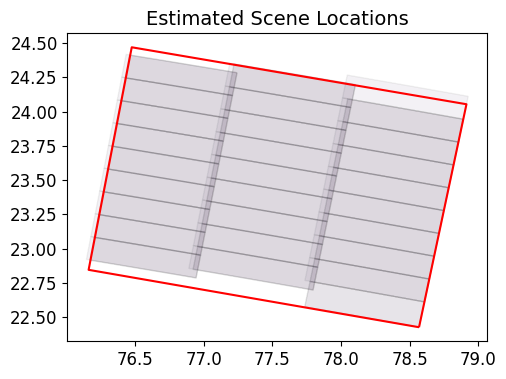

In [64]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

# Reframe Scenes (Optional)**bold text**

In [ ]:
# Define your area of interest (AOI) as a bounding box [lon_min, lon_max, lat_min, lat_max]
AOI = [lon_min, lon_max, lat_min, lat_max]

# Compute reframe
sbas.compute_reframe(AOI)
